In [61]:
# A microsim model for the Gastric Base Case

# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
from sklearn.metrics import mean_squared_error  # For objective function
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from collections import Counter
import statistics


# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=400, formatter={'float': '{: 0.6f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



In [62]:
# Importing Markov calibrated transition matrices
sexes = ['Female','Male']
races = ['NH Black','NH White']


# State Structure
health_states = {'Healthy':0,'H. Pylori':1,'Atrophic Gastritis':2, 'AG (HP)':3,'Intestinal Metaplasia':4, 'IM (HP)':5, 'Dysplasia':6, 'Dysplasia (HP)':7,
                'Undetected GC I':8, 'Undetected GC II':9, 'Undetected GC III':10, 'Undetected GC IV':11, 
                'Detected GC I':12,'Detected GC II':13,'Detected GC III':14,'Detected GC IV':15, 
                'Cancer Death':16, 'Other Death':17}

tmat = np.load("Transition Matrices\\Basecase.npy")


# Smooth interpolation over ages
tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], tmat, smooth=0.01, axis=2)(np.linspace(18,100,83)).clip(0.0, 1.0)

# Normalizing Columns
def col_normalize(matrix):
    matrix = np.clip(matrix, 0.0, 0.6)
    # Iterate over the first three dimensions to access each 18x18 matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            for k in range(matrix.shape[2]):
                layer = matrix[i, j, k]
                # Calculate the sum of non-diagonal elements for each column
                sum_of_columns = np.sum(layer, axis=0) - np.diag(layer)
                # Set the diagonal elements
                np.fill_diagonal(layer, 1 - sum_of_columns)
    return matrix


tmat = col_normalize(tmat)

# Loading HP 
hp_gen = pd.read_csv("Inputs and Targets\\HP (Basecase).csv")
hp_18 = hp_gen[hp_gen['Age'] < 18][['NH Black','NH White']].sum().to_numpy()

# Loading in Survival Hazards
hazards = pd.read_csv("Inputs and Targets\\Hazards.csv")
hazards = hazards.groupby(['AGE','SEX','RACE','STAGE','YEARS'])[['OD_HAZARD','CD_HAZARD']].mean()
hazards = hazards.sort_values(by=['SEX','RACE','STAGE','AGE','YEARS']).reset_index()
hazards = hazards[['OD_HAZARD','CD_HAZARD']].to_numpy().reshape(2,2,4,11,11,2)  # sex, race, stage, age, years, hazard
# Smooth interpolation over ages
hazards = csaps([15,35,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], hazards, smooth=0.01, axis=3)(np.linspace(18,100,83)).clip(0.0, 1.0)
# Adding a column of zeros to the end
hazards = np.concatenate((hazards, np.zeros((2,2,4,83,11,1))), axis=5)  # this stores the no event probability
hazards[:,:,:,:,:,2] = 1.0 - hazards[:,:,:,:,:,0] - hazards[:,:,:,:,:,1]

# Sanity Check
print(np.amin(tmat), np.amax(tmat))

0.0 1.0


In [ ]:
# Visualizing Transition Matrix parameters
# Shape (2,2,10,18,18)
plt.plot(tmat[0,0,:,2,0])
plt.plot(tmat[0,0,:,3,1])
plt.plot(tmat[0,0,:,4,2])
plt.show()

plt.plot(tmat[0,0,:,5,3])
plt.plot(tmat[0,0,:,6,4])
plt.plot(tmat[0,0,:,7,5])
plt.show()
plt.plot(tmat[0,0,:,8,6])
plt.plot(tmat[0,0,:,8,7])
plt.plot(tmat[0,0,:,9,8])
plt.show()
plt.plot(tmat[0,0,:,10,9])
plt.plot(tmat[0,0,:,11,10])
plt.plot(tmat[0,0,:,12,8])
plt.show()
plt.plot(tmat[0,0,:,13,9])
plt.plot(tmat[0,0,:,14,10])
plt.plot(tmat[0,0,:,15,11])
plt.show()
plt.plot(tmat[0,0,:,8,0])
plt.plot(tmat[0,0,:,8,1])
plt.show()





In [69]:
# Microsim Class

class Person:
    def __init__(self, sex=0, race=0, start_state=0):
        self.current_state = start_state
        self.sex = sex
        self.race = race
        self.state_history = [(self.current_state, 0)]  # Memory of previous states, only appends when a state changes to save memory.
        self.treat_flag = 0

    def __repr__(self):
        return f"Sex:{self.sex}, Race:{self.race}, Current State:{self.current_state}"


class TransitionMatrix:
    """A class that contains transition matrix information and is iterable."""
    def __init__(self):
        # Creating stack of arrays for each sex/race combination, Dimensions: age bucket (10 years), demographic, out_state, in_state
        self.matrix = None  # Placeholder for ease of reading
        self.treat_mat = None
    
    def create_mat(self, loadin):
        self.matrix = loadin
        self.treat_mat = np.copy(self.matrix)
        self.treat_mat[:,:,:,1,0] = 0.0
        self.treat_mat[:,:,:,3,2] = 0.0
        self.treat_mat[:,:,:,5,4] = 0.0
        self.treat_mat[:,:,:,7,6] = 0.0
        self.treat_mat = col_normalize(self.treat_mat)


    def get_probability(self, person, age):
        if person.treat_flag == 0:
            return self.matrix[person.sex, person.race, age-18, :, person.current_state]
        else:
            return self.treat_mat[person.sex, person.race, age-18, :, person.current_state]



class Microsimulation():
    def __init__(self, N=100000, sex='Female', race='NH Black'):
        self.health_states = health_states
        self.age = 18
        self.clock = 0
        self.tmat = TransitionMatrix()
        self.pop = set()
        self.N = N
        if sex == 'Female':
            if race == 'NH Black':
                for i in range(int(N*(1-hp_18[0]))):
                    self.pop.add(Person(0,0,0))  # NH Black Female, no HP
                for i in range(int(N*(hp_18[0]))):
                    self.pop.add(Person(0,0,1))  # NH Black Female, with HP
            else:
                for i in range(int(N*(1-hp_18[1]))):
                    self.pop.add(Person(0,1,0))  # NH White Female, no HP
                for i in range(int(N*(hp_18[1]))):
                    self.pop.add(Person(0,1,1))  # NH White Female, with HP
        else:
            if race == 'NH Black':
                for i in range(int(N*(1-hp_18[0]))):
                    self.pop.add(Person(1,0,0))  # NH Black Male, no HP
                for i in range(int(N*(hp_18[0]))):
                    self.pop.add(Person(1,0,1))  # NH Black Male, with HP
            else:
                for i in range(int(N*(1-hp_18[1]))):
                    self.pop.add(Person(1,1,0))  # NH White Male, no HP
                for i in range(int(N*(hp_18[1]))):
                    self.pop.add(Person(1,1,1))  # NH White Male, with HP

    def run(self):
        for person in self.pop:
            self.age = 18
            self.clock = 0
            while self.age < 100 and person.current_state not in [16,17]:
                if person.current_state in [12,13,14,15]:
                    duration = (self.clock - person.state_history[-1][1])//12
                    if duration > 10:
                        person.current_state = 0  # alive after 10 years
                    else:
                        outcome = np.random.multinomial(1, hazards[person.sex, person.race, person.current_state-12, self.age-18, duration], 1).argmax()
                        if outcome == 0:
                            person.current_state = 17  # Other Death
                        elif outcome == 1:
                            person.current_state = 16  # Cancer Death

                person.current_state = np.random.multinomial(1, self.tmat.get_probability(person, self.age), 1).argmax()
                if person.current_state != person.state_history[-1][0]:
                    person.state_history.append((person.current_state, self.clock))
                self.clock += 1
                if self.clock%12==0:
                    self.age += 1
        self.get_ledger()
    
    def mclir(self, scenario_num):
        if scenario_num == 1:
            for person in self.pop:
                self.age = 18
                self.clock = 0
                while self.age < 100 and person.current_state not in [16,17]:
                    person.current_state = np.random.multinomial(1, self.tmat.get_probability(person, self.age), 1).argmax()
                    if person.current_state != person.state_history[-1][0]:
                        person.state_history.append((person.current_state, self.clock))
                    if self.age == 20:
                        if person.current_state in [1,3,5,7]:
                            person.current_state = 0
                            person.treat_flag = 1
                            person.state_history.append((person.current_state, self.clock))
                        elif person.current_state in [8,9,10,11]:
                            # checking if they have hp in history
                            if 7 in [entry[0] for entry in person.state_history]:
                                person.current_state = 0
                                person.treat_flag = 1
                                person.state_history.append((person.current_state, self.clock))
                    self.clock += 1
                    if self.clock%12==0:
                        self.age += 1
            self.get_ledger()
        elif scenario_num == 2:
            for person in self.pop:
                self.age = 18
                self.clock = 0
                while self.age < 100 and person.current_state not in [16,17]:
                    person.current_state = np.random.multinomial(1, self.tmat.get_probability(person, self.age), 1).argmax()
                    if person.current_state != person.state_history[-1][0]:
                        person.state_history.append((person.current_state, self.clock))
                    if self.age == 65:
                        if person.current_state in [1,3,5,7]:
                            person.current_state = 0
                            person.treat_flag = 1
                            person.state_history.append((person.current_state, self.clock))
                        elif person.current_state in [8,9,10,11]:
                            # checking if they have hp in history
                            if 7 in [entry[0] for entry in person.state_history]:
                                person.current_state = 0
                                person.treat_flag = 1
                                person.state_history.append((person.current_state, self.clock))
                    self.clock += 1
                    if self.clock%12==0:
                        self.age += 1
                    
            self.get_ledger()        
        elif scenario_num == 3:
            for person in self.pop:
                self.age = 18
                self.clock = 0
                while self.age < 100 and person.current_state not in [16,17]:
                    person.current_state = np.random.multinomial(1, self.tmat.get_probability(person, self.age), 1).argmax()
                    if person.current_state != person.state_history[-1][0]:
                        person.state_history.append((person.current_state, self.clock))
                    if self.age == 65:
                        if person.current_state in [2,4,6]:
                            person.current_state = 0
                            person.state_history.append((person.current_state, self.clock))
                        elif person.current_state in [3,5,7]:
                            person.current_state = 1
                            person.state_history.append((person.current_state, self.clock))
                        elif person.current_state in [8,9,10,11,12,13,14,15]:
                            # checking if they have hp in history
                            have_hp = 0
                            for entry in person.state_history:
                                if entry[0] == 1:
                                    have_hp += 1
                            if have_hp >= 1:
                                person.current_state = 1
                                person.state_history.append((person.current_state, self.clock))
                            else:
                                person.current_state = 0
                                person.state_history.append((person.current_state, self.clock))
                    self.clock += 1
                    if self.clock%12==0:
                        self.age += 1
                    
            self.get_ledger()
        else:
            for person in self.pop:
                self.age = 18
                self.clock = 0
                while self.age < 100 and person.current_state not in [16,17]:
                    person.current_state = np.random.multinomial(1, self.tmat.get_probability(person, self.age), 1).argmax()
                    if person.current_state != person.state_history[-1][0]:
                        person.state_history.append((person.current_state, self.clock))
                    if self.age == 65:
                        if person.current_state not in [0,16,17]:
                            person.current_state = 0
                            person.state_history.append((person.current_state, self.clock))    
                    self.clock += 1
                    if self.clock%12==0:
                        self.age += 1
                    
            self.get_ledger()
        
    def get_ledger(self):
        self.ledger = []
        for person in self.pop:
            self.ledger.append(person.state_history)
    
    def reset(self):
        self.age = 18
        self.clock = 0
        self.pop = set()
        while len(self.pop) < self.N:
            self.pop.add(Person())

    def get_incidence(self):
        em_inc = []
        for history in self.ledger:
            for change in history:
                if change[0] == 6:
                    em_inc.append(18 + change[1]//12)
        return em_inc
    
    def mean_dwell_time(self):
        dwell_times = []  # list of tuples with (state_num, dwell_time)
        for history in self.ledger:
            for i in range(len(history)):
                if i == len(history)-1:
                    dwell_times.append((history[i][0], 804 - history[i][1]))
                else:
                    dwell_times.append((history[i][0], history[i+1][1] - history[i][1]))
        mean_times = []
        for state_name, state_num in self.health_states.items():
            times = []
            for dt in dwell_times:
                if dt[0] == state_num:
                    times.append(dt[1])
            mean_times.append((state_name, state_num, np.mean(times), np.median(times), statistics.stdev(times)))
        return mean_times
    
    def diagnostics(self):
        log = []
        for state_num in self.health_states.values():
            for history in self.ledger:
                for entry_num in range(len(history)):
                    if entry_num == len(history)-1 and history[entry_num][0] == state_num:
                        log.append((state_num, state_num, 804 - history[entry_num][1]))  # old state, new state, time taken
                    elif history[entry_num][0] == state_num:
                        log.append((state_num, history[entry_num+1][0], history[entry_num+1][1] - history[entry_num][1]))  # old state, new state, time taken
        return log

    def get_output(self):
        """gets the denominator adjusted incidence for EIN, EM C and Non-EM C"""
        self.run()
        num_persons = self.N
        denom = []
        for person in self.ledger:
            if person[-1][0] in [7,8,9]:
                denom.append(18 + person[-1][1]//12)
        dummy = Counter(denom)
        dummy = sorted(dummy.items(), key=lambda pair: pair[0])
        denom = np.zeros(85)
        for pair in dummy:
            denom[pair[0]] = pair[1]
        denom = (num_persons - np.cumsum(denom))/num_persons

        dummy = Counter(self.get_incidence()[0])
        dummy = sorted(dummy.items(), key=lambda pair: pair[0])
        em_inc = np.zeros(85)
        for pair in dummy:
            em_inc[pair[0]] = pair[1]
        em_inc = np.divide(em_inc, denom)

        dummy = Counter(self.get_incidence()[1])
        dummy = sorted(dummy.items(), key=lambda pair: pair[0])
        non_inc = np.zeros(85)
        for pair in dummy:
            non_inc[pair[0]] = pair[1]
        non_inc = np.divide(non_inc, denom)

        em_inc = csaps(np.linspace(0,84,85), em_inc, smooth=0.01)(np.linspace(0,83,84)).clip(0.0, 10000)
        non_inc = csaps(np.linspace(0,84,85), non_inc, smooth=0.01)(np.linspace(0,83,84)).clip(0.0, 10000)
        return em_inc, non_inc




In [ ]:
ledger_list = []
num_persons = 5_000_000

for sex in sexes:
    for race in races:
        for scenario in range(5):
            print(sex, race, scenario)
            test = Microsimulation(N=num_persons, sex=sex, race=race)  # 5mins for 100k pop
            test.tmat.create_mat(tmat)
            if scenario == 0:
                test.run()
                ledger_list.append(test.ledger)
            else:
                # test.mclir(scenario_num=scenario)
                #ledger_list.append(test.ledger)
                pass


# 10k takes 420 secs
# 100k takes 70 mins
# 1mil takes 11.5hrs
# 5mil takes 55.5hrs


# Est completion: Wednesday 1pm


In [11]:




bf0 = ledger_list[0]
bf1 = ledger_list[1]
bf2 = ledger_list[2]
bf3 = ledger_list[3]
bf4 = ledger_list[4]
wf0 = ledger_list[5]
wf1 = ledger_list[6]
wf2 = ledger_list[7]
wf3 = ledger_list[8]
wf4 = ledger_list[9]
bm0 = ledger_list[10]
bm1 = ledger_list[11]
bm2 = ledger_list[12]
bm3 = ledger_list[13]
bm4 = ledger_list[14]
wm0 = ledger_list[15]
wm1 = ledger_list[16]
wm2 = ledger_list[17]
wm3 = ledger_list[18]
wm4 = ledger_list[19]

In [39]:


# Now from prevalence I need to sum to get Duco's Columns
def duco(log, scenario, alt=0):
    pop = np.zeros((83, 18))  # each row is the number of people in each state at that point in time
    output = np.zeros((83, 15))  # Duco's output format

    for history in log:  # history is a list of tuples (state_num, month)
        for i in range(len(history)):
            if i == len(history) - 1:  # final state
                pop[history[i][1]//12:, history[i][0]] += 1
            else:
                pop[history[i][1]//12:history[i+1][1]//12, history[i][0]] += 1
            if history[i][0] in [12,13,14,15]:
                output[history[i][1]//12, history[i][0]-10] += 1

    output[:,0] = pop[:,:16].sum(axis=1)  # n_alive
    output[:,1] = pop[:,:8].sum(axis=1)  # n_alive_no_GC


    if scenario == 1:
        output[2:,7] = pop[1,1]+pop[1,3]+pop[1,5]+pop[1,7]  # n_removal_hp
        output[2:,8] = pop[1,3]  # n_removal_AG
        output[2:,9] = pop[1,5]  # n_removal_IM
        output[2:,10] = pop[1,7]  # n_removal_Dysp
        output[2:,11] = pop[1,8] - pop[2,8]  # n_removal_GC1
        output[2:,12] = pop[1,9] - pop[2,9]  # n_removal_GC2
        output[2:,13] = pop[1,10] - pop[2,10]  # n_removal_GC3
        output[2:,14] = pop[1,11] - pop[2,11]  # n_removal_GC4
    elif scenario == 2:
        output[47:,7] = pop[46,1]+pop[46,3]+pop[46,5]+pop[46,7]  # n_removal_hp
        output[47:,8] = pop[46,3]  # n_removal_AG
        output[47:,9] = pop[46,5]  # n_removal_IM
        output[47:,10] = pop[46,7]  # n_removal_Dysp
        output[47:,11] = pop[46,8] - pop[47,8]  # n_removal_GC1
        output[47:,12] = pop[46,9] - pop[47,9]  # n_removal_GC2
        output[47:,13] = pop[46,10] - pop[47,10]  # n_removal_GC3
        output[47:,14] = pop[46,11] - pop[47,11]  # n_removal_GC4
    elif scenario == 3:
        output[47:,7] = 0 # n_removal_hp
        output[47:,8] = pop[46,2] + pop[46,3]  # n_removal_AG
        output[47:,9] = pop[46,4] + pop[46,5]  # n_removal_IM
        output[47:,10] = pop[46,6] + pop[46,7]  # n_removal_Dysp
        output[47:,11] = pop[46,8]  # n_removal_GC1
        output[47:,12] = pop[46,9]  # n_removal_GC2
        output[47:,13] = pop[46,10]  # n_removal_GC3
        output[47:,14] = pop[46,11]  # n_removal_GC4
    elif scenario == 4:
        output[47:,7] = pop[46,1]+pop[46,3]+pop[46,5]+pop[46,7]  # n_removal_hp
        output[47:,8] = pop[46,2] + pop[46,3]  # n_removal_AG
        output[47:,9] = pop[46,4] + pop[46,5]  # n_removal_IM
        output[47:,10] = pop[46,6] + pop[46,7]  # n_removal_Dysp
        output[47:,11] = pop[46,8]  # n_removal_GC1
        output[47:,12] = pop[46,9]  # n_removal_GC2
        output[47:,13] = pop[46,10]  # n_removal_GC3
        output[47:,14] = pop[46,11]  # n_removal_GC4
    if alt == 1:  # For returning incidence rate
        tmp = np.zeros((output.shape[0],2))
        tmp[:,0] += output[:,0]
        tmp[:,1] = output[:,2] + output[:,3] + output[:,4] + output[:,5] 
        return 100000*tmp[:-1,1]/tmp[:-1,0]
    else:
        return output

test = duco(wm4, 4, alt=0)
pd.DataFrame(test).to_clipboard(index=False,header=False)



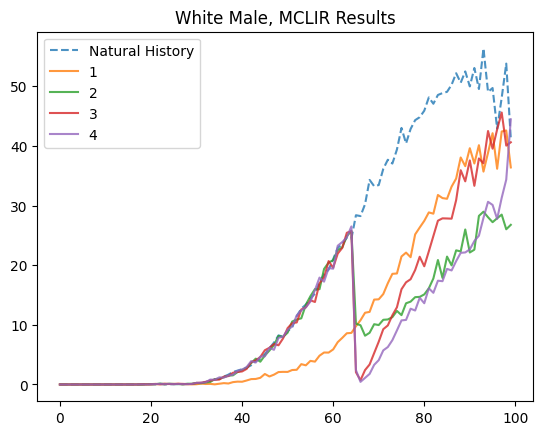

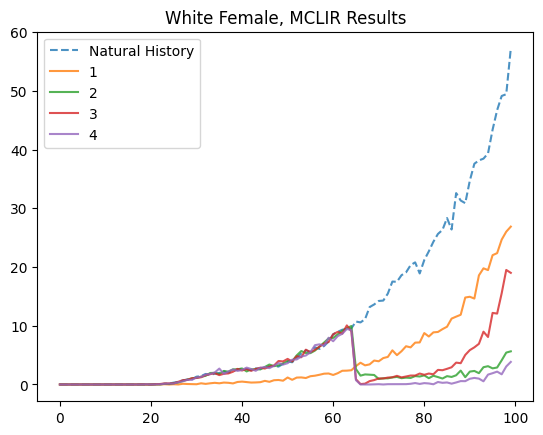

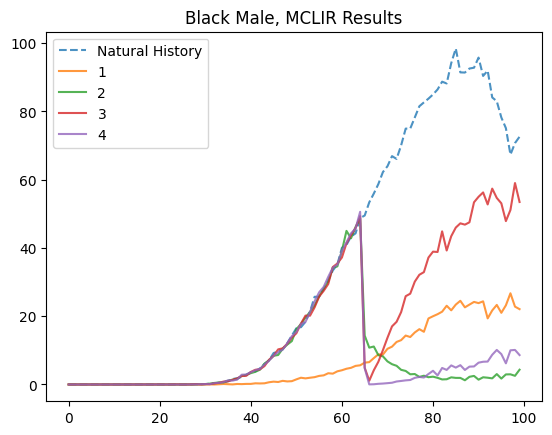

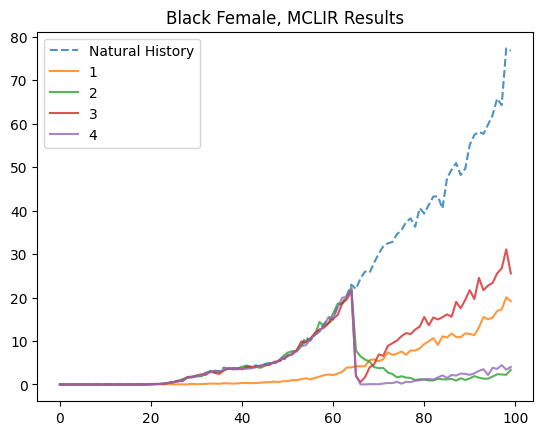

In [13]:

wm = np.zeros((100,5))
wm[18:,0] = duco(wm0, 0, alt=1)
wm[18:,1] = duco(wm1, 1, alt=1)
wm[18:,2] = duco(wm2, 2, alt=1)
wm[18:,3] = duco(wm3, 3, alt=1)
wm[18:,4] = duco(wm4, 4, alt=1)

plt.plot(wm[:,0], label='Natural History', alpha=0.8, ls='--')
plt.plot(wm[:,1], label='1', alpha=0.8)
plt.plot(wm[:,2], label='2', alpha=0.8)
plt.plot(wm[:,3], label='3', alpha=0.8)
plt.plot(wm[:,4], label='4', alpha=0.8)
plt.title('White Male, MCLIR Results')
plt.legend()
plt.show()

wf = np.zeros((100,5))
wf[18:,0] = duco(wf0, 0, alt=1)
wf[18:,1] = duco(wf1, 1, alt=1)
wf[18:,2] = duco(wf2, 2, alt=1)
wf[18:,3] = duco(wf3, 3, alt=1)
wf[18:,4] = duco(wf4, 4, alt=1)

plt.plot(wf[:,0], label='Natural History', alpha=0.8, ls='--')
plt.plot(wf[:,1], label='1', alpha=0.8)
plt.plot(wf[:,2], label='2', alpha=0.8)
plt.plot(wf[:,3], label='3', alpha=0.8)
plt.plot(wf[:,4], label='4', alpha=0.8)
plt.title('White Female, MCLIR Results')
plt.legend()
plt.show()

bm = np.zeros((100,5))
bm[18:,0] = duco(bm0, 0, alt=1)
bm[18:,1] = duco(bm1, 1, alt=1)
bm[18:,2] = duco(bm2, 2, alt=1)
bm[18:,3] = duco(bm3, 3, alt=1)
bm[18:,4] = duco(bm4, 4, alt=1)

plt.plot(bm[:,0], label='Natural History', alpha=0.8, ls='--')
plt.plot(bm[:,1], label='1', alpha=0.8)
plt.plot(bm[:,2], label='2', alpha=0.8)
plt.plot(bm[:,3], label='3', alpha=0.8)
plt.plot(bm[:,4], label='4', alpha=0.8)
plt.title('Black Male, MCLIR Results')
plt.legend()
plt.show()

bf = np.zeros((100,5))
bf[18:,0] = duco(bf0, 0, alt=1)
bf[18:,1] = duco(bf1, 1, alt=1)
bf[18:,2] = duco(bf2, 2, alt=1)
bf[18:,3] = duco(bf3, 3, alt=1)
bf[18:,4] = duco(bf4, 4, alt=1)

plt.plot(bf[:,0], label='Natural History', alpha=0.8, ls='--')
plt.plot(bf[:,1], label='1', alpha=0.8)
plt.plot(bf[:,2], label='2', alpha=0.8)
plt.plot(bf[:,3], label='3', alpha=0.8)
plt.plot(bf[:,4], label='4', alpha=0.8)
plt.title('Black Female, MCLIR Results')
plt.legend()
plt.show()


In [14]:
# Output Summary: total lifetime incidence, reduction by scenario 1,2,3,4

bf_sum = bf.sum(axis=0)
bf_sum[1] = 100*(bf_sum[0]-bf_sum[1])/bf_sum[0]
bf_sum[2] = 100*(bf_sum[0]-bf_sum[2])/bf_sum[0]
bf_sum[3] = 100*(bf_sum[0]-bf_sum[3])/bf_sum[0]
bf_sum[4] = 100*(bf_sum[0]-bf_sum[4])/bf_sum[0]
bf_sum

array([ 1846.943564,  78.718489,  80.212665,  56.930143,  81.763109])

In [15]:
wf_sum = wf.sum(axis=0)
wf_sum[1] = 100*(wf_sum[0]-wf_sum[1])/wf_sum[0]
wf_sum[2] = 100*(wf_sum[0]-wf_sum[2])/wf_sum[0]
wf_sum[3] = 100*(wf_sum[0]-wf_sum[3])/wf_sum[0]
wf_sum[4] = 100*(wf_sum[0]-wf_sum[4])/wf_sum[0]
wf_sum

array([ 1092.446377,  61.612690,  79.717495,  71.561962,  84.183251])

In [16]:
bm_sum = bm.sum(axis=0)
bm_sum[1] = 100*(bm_sum[0]-bm_sum[1])/bm_sum[0]
bm_sum[2] = 100*(bm_sum[0]-bm_sum[2])/bm_sum[0]
bm_sum[3] = 100*(bm_sum[0]-bm_sum[3])/bm_sum[0]
bm_sum[4] = 100*(bm_sum[0]-bm_sum[4])/bm_sum[0]
bm_sum

array([ 3303.119159,  79.117086,  78.885468,  44.712323,  78.352874])

In [17]:
wm_sum = wm.sum(axis=0)
wm_sum[1] = 100*(wm_sum[0]-wm_sum[1])/wm_sum[0]
wm_sum[2] = 100*(wm_sum[0]-wm_sum[2])/wm_sum[0]
wm_sum[3] = 100*(wm_sum[0]-wm_sum[3])/wm_sum[0]
wm_sum[4] = 100*(wm_sum[0]-wm_sum[4])/wm_sum[0]
wm_sum

array([ 1859.790362,  42.902872,  48.611731,  38.297547,  51.421967])

In [18]:
# Comparing incidence to SEER data
incidence = np.zeros((100,4))
incidence[18:,0] = duco(bf0, 0, alt=1)
incidence[18:,1] = duco(wf0, 0, alt=1)
incidence[18:,2] = duco(bm0, 0, alt=1)
incidence[18:,3] = duco(wm0, 0, alt=1)

seer_inc = pd.read_csv('Inputs and Targets\\Incidence (Basecase).csv')
seer_inc['error_min'] = seer_inc['Rate'] - seer_inc['Lower']
seer_inc['error_max'] = seer_inc['Upper'] - seer_inc['Rate']

seer_bw = seer_inc[(seer_inc['Sex'] == 'Female') & (seer_inc['Race'] == 'NH Black')]
seer_ww = seer_inc[(seer_inc['Sex'] == 'Female') & (seer_inc['Race'] == 'NH White')]
seer_bm = seer_inc[(seer_inc['Sex'] == 'Male') & (seer_inc['Race'] == 'NH Black')]
seer_wm = seer_inc[(seer_inc['Sex'] == 'Male') & (seer_inc['Race'] == 'NH White')]



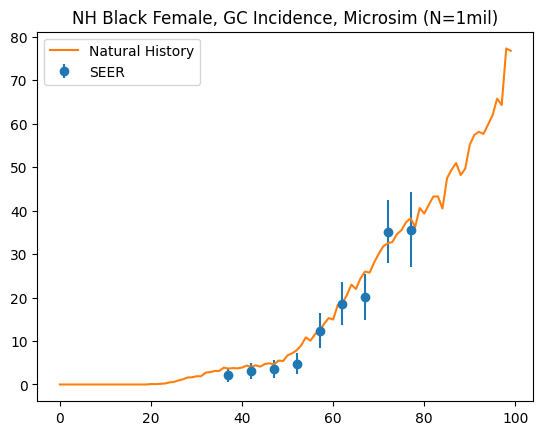

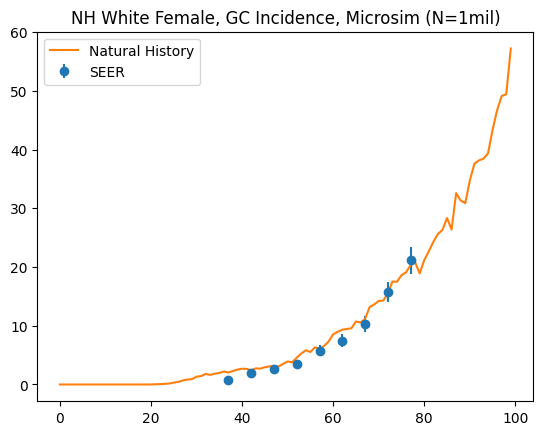

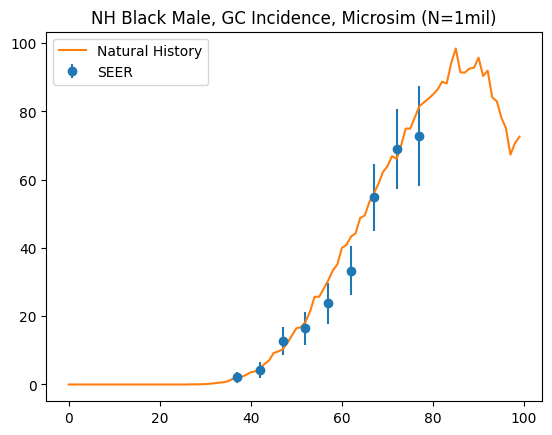

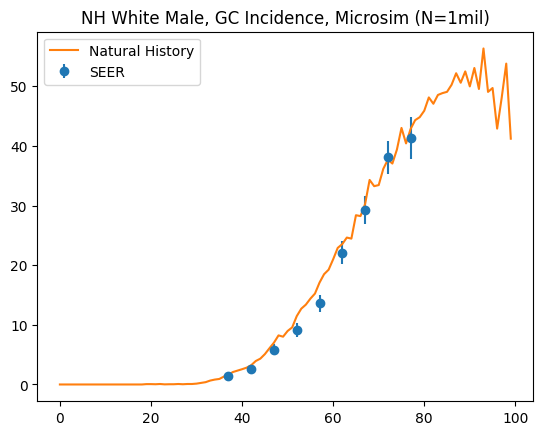

In [19]:
# Plotting incidence against SEER


plt.errorbar(seer_bw['Age'], seer_bw['Rate'], yerr=[seer_bw['error_min'], seer_bw['error_max']], label='SEER', fmt='o')
plt.plot(incidence[:,0], label='Natural History')
plt.legend()
plt.title("NH Black Female, GC Incidence, Microsim (N=1mil)")
plt.show()

plt.errorbar(seer_ww['Age'], seer_ww['Rate'], yerr=[seer_ww['error_min'], seer_ww['error_max']], label='SEER', fmt='o')
plt.plot(incidence[:,1], label='Natural History')
plt.legend()
plt.title("NH White Female, GC Incidence, Microsim (N=1mil)")
plt.show()

plt.errorbar(seer_bm['Age'], seer_bm['Rate'], yerr=[seer_bm['error_min'], seer_bm['error_max']], label='SEER', fmt='o')
plt.plot(incidence[:,2], label='Natural History')
plt.legend()
plt.title("NH Black Male, GC Incidence, Microsim (N=1mil)")
plt.show()

plt.errorbar(seer_wm['Age'], seer_wm['Rate'], yerr=[seer_wm['error_min'], seer_wm['error_max']], label='SEER', fmt='o')
plt.plot(incidence[:,3], label='Natural History')
plt.legend()
plt.title("NH White Male, GC Incidence, Microsim (N=1mil)")
plt.show()


